# 自己回帰（AutoRegression）ベースの異常検知
* まずは時系列データの異常検知を理解するためにもっともシンプルなモデルであるAR（AutoRegression、自己回帰）モデルを使ってみます。

In [1]:
import os
from cmdstanpy import CmdStanModel
from pathlib import Path
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

/home/karinog/miniconda3/envs/cmdstanpy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## データ生成

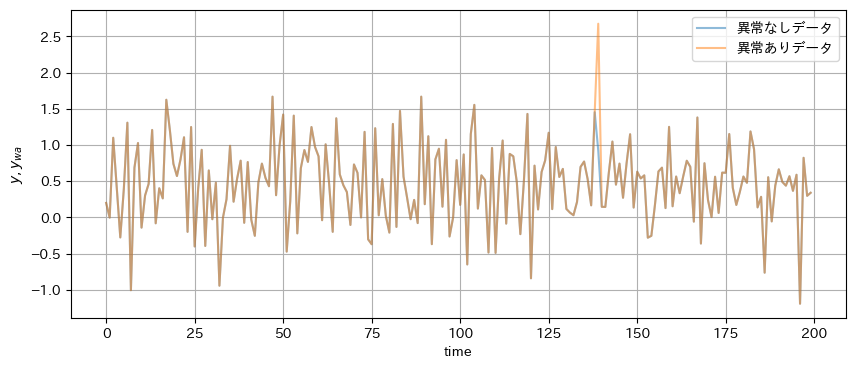

In [2]:
sigma = 0.5
y = np.zeros(200)
y[0] = 0.2
alpha = 0.6
beta = -0.3

np.random.seed(123)
for n in range(1,y.size):
    y[n] = np.random.normal(alpha + beta*y[n-1], sigma)
y_wa = y.copy()

# 異常を入れる
# インデックス番号139番目に異なるモデルから生成したデータを入れる
n = 139
y_wa[n] = np.random.normal(alpha*7 + 3*beta*y_wa[n-1], sigma*2)

plt.figure(figsize=(10,4))
plt.plot(y, label="異常なしデータ", alpha=0.5)
plt.plot(y_wa, label="異常ありデータ", alpha=0.5)
plt.xlabel("time")
plt.ylabel("$y, y_{wa}$")
plt.grid()
plt.legend()
plt.show()

## モデル読込み・学習

In [3]:

path = Path("../models_ts")
stanfile = path / "ar.stan"

model = CmdStanModel(stan_file=stanfile)

In [4]:
data = {
 "N_tr" : 100,
 "N_te" : 100,
 "y_tr" : y_wa[:100],  # 前半が学習データ
 "y_te" : y_wa[100:]  # 後半がテストデータ
}
fit = model.sample(
    data=data,
    iter_warmup=300, iter_sampling=1000, chains=3, show_console=False,
    adapt_delta=0.99,
    max_treedepth=20,
)

17:29:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▋     | 00:00 Iteration:  400 / 1300 [ 30%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       


17:29:11 - cmdstanpy - INFO - CmdStan done processing.


In [5]:
# 念の為診断
print(fit.diagnose())

Processing csv files: /tmp/tmpdf99inpe/ar1kalbrlf/ar-20230810172910_1.csv, /tmp/tmpdf99inpe/ar1kalbrlf/ar-20230810172910_2.csv, /tmp/tmpdf99inpe/ar1kalbrlf/ar-20230810172910_3.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



## 結果の確認

In [6]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,4.764230,0.045722,1.477230,1.926900,5.130570,6.439210,1043.85,1433.85,0.999575
alpha0,0.206534,0.012311,0.586972,-0.756521,0.200618,1.173650,2273.20,3122.53,0.999256
alpha,0.602036,0.001973,0.076657,0.476884,0.600193,0.734006,1509.91,2074.06,1.000110
beta,-0.268802,0.002681,0.100151,-0.437076,-0.268777,-0.105771,1395.85,1917.38,0.999984
sigma,0.579281,0.000862,0.041045,0.516691,0.576843,0.651048,2269.31,3117.19,1.000670
...,...,...,...,...,...,...,...,...,...
log_lik_te[96],-0.845174,0.012250,0.669439,-2.150770,-0.601570,-0.318472,2986.39,4102.19,1.000450
log_lik_te[97],-4.897490,0.055527,3.012660,-10.614800,-4.303200,-1.080960,2943.64,4043.46,0.999988
log_lik_te[98],-0.945051,0.016420,0.838938,-2.574060,-0.633676,-0.325773,2610.42,3585.74,1.000030
log_lik_te[99],-0.857272,0.012514,0.676923,-2.261140,-0.597348,-0.318856,2925.90,4019.09,0.999660


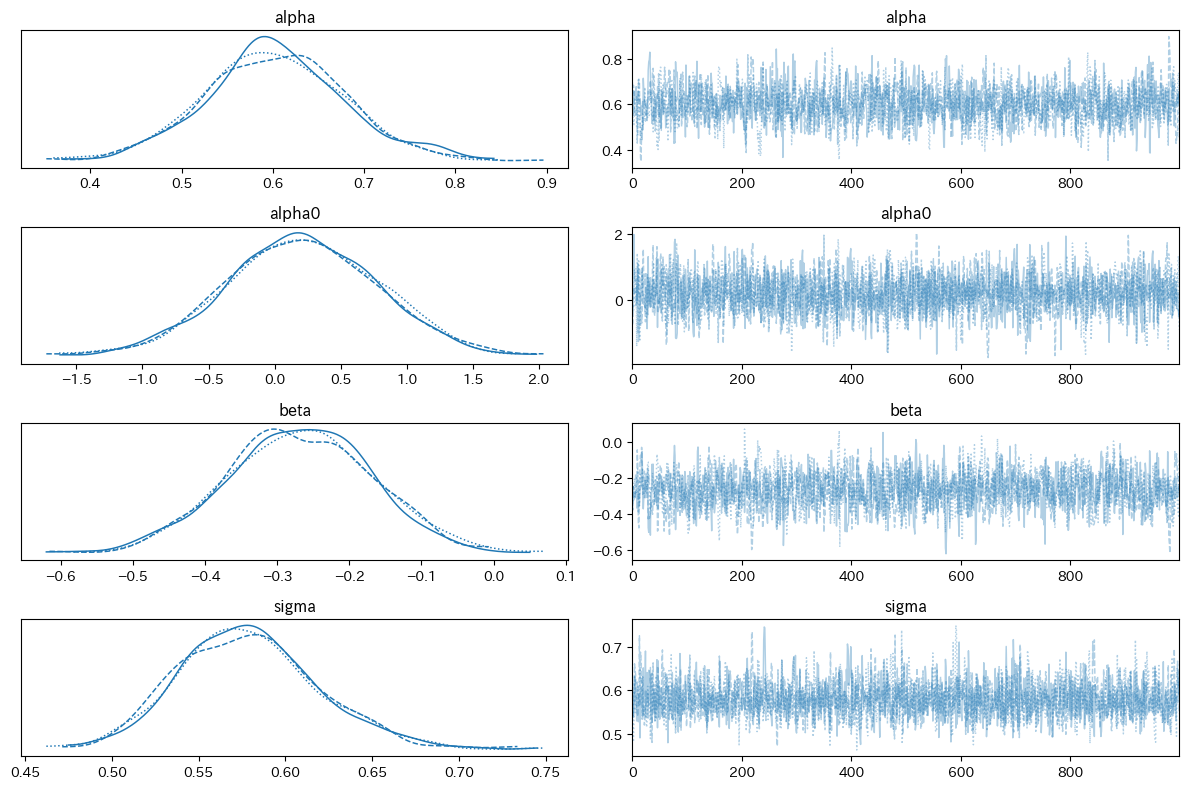

In [7]:
output = az.from_cmdstanpy(posterior=fit)
az.plot_trace(output, var_names=["alpha","alpha0","beta","sigma"])
plt.tight_layout()

## EAP推定
* 対数尤度が「異常度」の指標になる
* $\log L(y | \hat y, \sigma)$の意味
    * モデルが$\hat y$を推定したときにデータが$y$を取りうる確率の対数
    * 発生確率が小さくなるほど対数尤度も小さくなる
    * 発生確率が小さい＝めったに起こらない＝異常！と考える

In [9]:
samples = fit.stan_variables()

alpha = samples["alpha"].mean(0)
alpha0 = samples["alpha0"].mean(0)
beta = samples["beta"].mean(0)
sigma = samples["sigma"].mean(0)
alpha, beta, sigma, alpha0

(0.6020357550000001, -0.26880240139333333, 0.57928103, 0.20653379956966667)

In [10]:
y_tr_hat_lower, y_tr_hat_upper = np.quantile(samples["y_tr_hat"], [0.025,0.975], axis=0)
y_tr_hat_mean = samples["y_tr_hat"].mean(0)
log_lik_tr_mean = samples["log_lik_tr"].mean(0)

y_te_hat_lower, y_te_hat_upper = np.quantile(samples["y_te_hat"], [0.025,0.975], axis=0)
y_te_hat_mean = samples["y_te_hat"].mean(0)
log_lik_te_mean = samples["log_lik_te"].mean(0)

/tmp/ipykernel_16224/2487494079.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


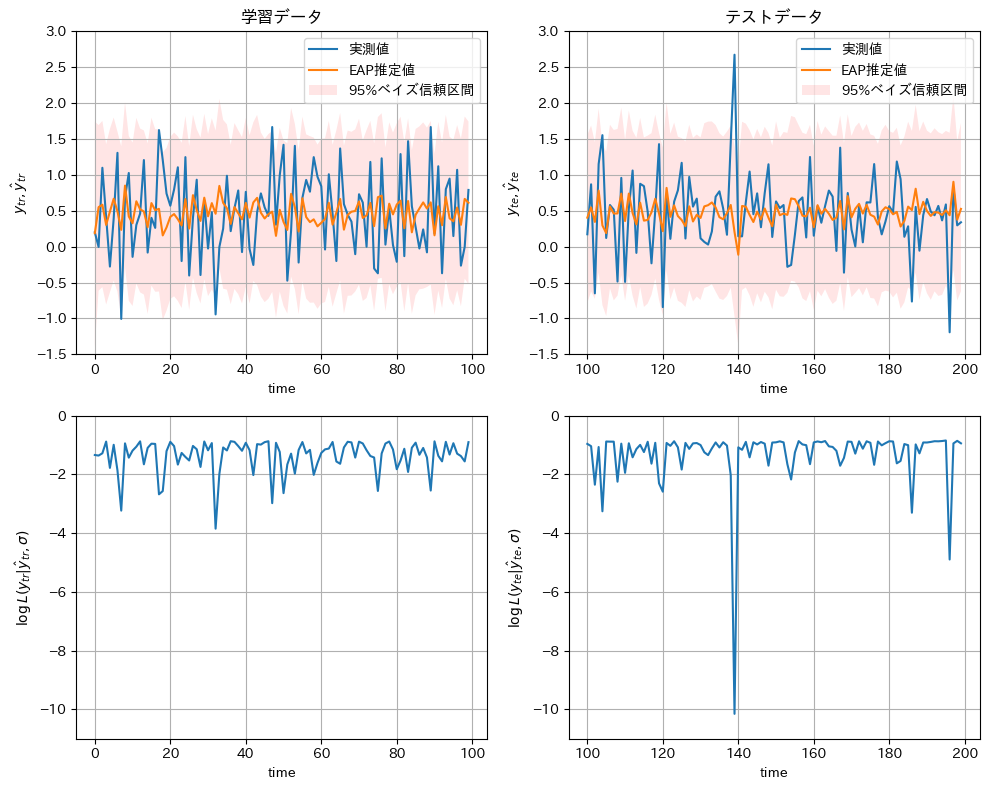

In [12]:
N_tr = 100
N_te = 100
fig,ax = plt.subplots(figsize=(10,8), ncols=2, nrows=2)
ax[0,0].set_title("学習データ")
ax[0,0].plot(np.arange(N_tr), y_wa[:100], label="実測値")
ax[0,0].plot(y_tr_hat_mean, label="EAP推定値")
ax[0,0].fill_between(np.arange(N_tr), y1=y_tr_hat_lower, y2=y_tr_hat_upper, alpha=0.1, color="r", edgecolor=None, label="95%ベイズ信頼区間")
ax[0,0].legend()
ax[0,0].set_ylabel("$y_{tr}, \hat y_{tr}$")
ax[0,0].set_xlabel("time")
ax[0,0].grid()
ax[0,0].set_ylim(-1.5, 3)

ax[0,1].set_title("テストデータ")
ax[0,1].plot(np.arange(N_tr, N_tr+N_te), y_wa[100:], label="実測値")
ax[0,1].plot(np.arange(N_tr, N_tr+N_te), y_te_hat_mean, label="EAP推定値")
ax[0,1].fill_between(np.arange(N_tr, N_tr+N_te), y1=y_te_hat_lower, y2=y_te_hat_upper, alpha=0.1, color="r", edgecolor=None, label="95%ベイズ信頼区間")
ax[0,1].legend()
ax[0,1].set_ylabel("$y_{te}, \hat y_{te}$")
ax[0,1].set_xlabel("time")
ax[0,1].grid()
ax[0,1].set_ylim(-1.5, 3)

ax[1,0].plot(log_lik_tr_mean)
ax[1,0].grid()
ax[1,0].set_xlabel("time")
ax[1,0].set_ylabel("$\log L(y_{tr} | \hat y_{tr}, \sigma)$")
ax[1,0].set_ylim(-11,0)

ax[1,1].plot(np.arange(N_tr, N_tr+N_te),log_lik_te_mean)
ax[1,1].grid()
ax[1,1].set_xlabel("time")
ax[1,1].set_ylabel("$\log L(y_{te} | \hat y_{te}, \sigma)$")
ax[1,1].set_ylim(-11,0)

fig.tight_layout()
fig.show()


* 実測値が95%ベイズ信頼区間からはみ出る（＝発生確率が小さいデータ）ほど対数尤度が小さくなっていることが確認できた。

EOF